# Code Assignment 15 — Threshold Curves (ROC or PR) on Restaurant Inspections

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **new** classification model (use **at least 2 features**) on NYC **Restaurant Inspection Results**. Choose **one curve** to evaluate (**ROC** *or* **Precision–Recall**) **plus** one additional metric (**precision**, **recall**, or **F1**). Justify your choice based on class imbalance and business costs.

> Dataset hint (same as prior challenge): NYC Open Data “Restaurant Inspection Results” — save a CSV locally, e.g. `./data/nyc_restaurant_inspections.csv`. Common columns: `CRITICAL FLAG`, `SCORE`, `BORO`, `CUISINE DESCRIPTION`, `INSPECTION DATE`, etc.


## Instructor Guidance (Pseudocode + Docs)

**Docs:**
- Train/test split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- ROC / AUC — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
- Precision–Recall — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html  
- Classification report — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  
- `get_dummies` — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.  
2) **Target (y)**: `CRITICAL FLAG == "CRITICAL"` → 1 else 0; check class balance.  
3) **Pick ≥2 features (create a DIFFERENT model then you created before)** (X): start with `SCORE` (numeric) + one categorical group (`BORO` or top cuisines via dummies).  
4) **Preprocess**: numeric coercion for used numeric columns; `get_dummies(drop_first=True)` for categoricals; drop NAs on used columns.  
5) **Split**: `train_test_split(..., stratify=y, random_state=42)`.  
6) **Fit**: `LogisticRegression(max_iter=1000)` on train.  
7) **Evaluate curves**:  
   - If **ROC**: use `predict_proba()[:,1]` → `roc_curve`, compute **AUC**.  
   - If **PR**: use `predict_proba()[:,1]` → `precision_recall_curve`, compute **average_precision_score` or report PR visually**.  
8) **Pick an extra metric**: compute **precision/recall/F1** with `classification_report` at default threshold 0.5 (or optionally choose a custom threshold -- which is IDEAL).  
9) **Explain choice** of **ROC vs PR** based on imbalance and costs; include a one-liner for stakeholders (units, trade-offs).


## Your Task — Step-by-Step
Work in pairs. Comment decisions briefly. Keep code minimal and readable.


### 1) Load the CSV & Preview


In [1]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


### 2) Define the Binary Target (y)
- Positive class = **Critical** violation.

In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104 copy.csv')

In [3]:
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location
0,50174196,THE GREATS OF CRAFT,Queens,47-20,CENTER BOULEVARD,11109.0,3479312023,NaN,01/01/1900,NaN,...,NaN,40.745641,-73.957137,402.0,26.0,100.0,4538318.0,4.000210e+09,QN31,POINT (-73.957136627525 40.745640668157)
1,50140563,CANTEEN @ CHELSEA PIERS FIELD HOUSE,Brooklyn,601,DEAN STREET,11238.0,6313880993,NaN,01/01/1900,NaN,...,NaN,40.680616,-73.969992,308.0,35.0,16300.0,3428601.0,3.000000e+09,BK64,POINT (-73.969992200023 40.68061568349)
2,50177123,70 7TH AVENUE SOUTH THEROS LLC,Queens,3009,35TH ST,11103.0,6468076482,NaN,01/01/1900,NaN,...,NaN,40.764778,-73.918674,401.0,22.0,6300.0,4009926.0,4.006500e+09,QN70,POINT (-73.918674354617 40.764778282908)
3,50001285,Y & B ENTERTAINMENT MANOR,Queens,3509,PRINCE STRRET,NaN,7188881778,Korean,06/24/2018,Violations were cited in the following area(s).,...,Smoke-Free Air Act / Initial Inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,4.000000e+00,NaN,NaN
4,50172517,MAPLE CREAMERY,Brooklyn,653,STERLING PLACE,11216.0,7188095106,NaN,01/01/1900,NaN,...,NaN,40.673255,-73.956830,308.0,35.0,21900.0,3031390.0,3.012380e+09,BK61,POINT (-73.956830036833 40.673255481805)


In [4]:
df['CRITICAL FLAG'].head()

0    Not Applicable
1    Not Applicable
2    Not Applicable
3    Not Applicable
4    Not Applicable
Name: CRITICAL FLAG, dtype: object

In [5]:
df['CRITICAL FLAG'].value_counts()

CRITICAL FLAG
Critical          153998
Not Critical      129318
Not Applicable      7962
Name: count, dtype: int64

In [6]:
df['CRITICAL FLAG'].isnull().sum()


0

In [7]:
# turn 'CRITICAL FLAG' into binary variable
df['critical_flag'] = df['CRITICAL FLAG'].apply(lambda x: 1 if x == 'Critical' else 0)

In [11]:
# define y as positive class = critical violation
y = df['critical_flag']

#### Recall: positive class
- In binary classifcation, we treat 1 class as most "important", it's labeled as 1  and everything else is 0
- So in this case, the critical violation is the positive class, if it's critical its 1 otherwise "not critical" and "not applicable" is 0
- Why do we do that? 
    - The goal here is to detect critical violations(the **important** event!)


##### To add!
Positive class is also important for metrics like:
- Precision, Recall, F1 are all calculated based on the positive class only.
- They basically ask: "How good is the model at finding the thing I care about the most?"

#### Examples 
- Fraud cases:
    - positive: fraud
    - negative: not fruad
- spam finders
    - positive = spam
    - negatie = not spam
- medical purposes
    - positive: disease
    - negtive: healthy 
    

### 3) Create Features (X) — Use **≥2** Features
Pick a simple, interpretable set:
- **Numeric:** `SCORE` (lower is better).
- **Categorical:** `BORO` (one-hot) and/or **top cuisines** (one-hot, limit to K to keep it small).

> If any column is missing, adapt by choosing other available columns.


In [8]:
# my x will be 'SCORE' column (lower is better) and 'BORO' column (one-hot encoded)
# first clean them them
print(df['SCORE'].isnull().sum())
print(df['BORO'].isnull().sum())

16339
0


In [9]:
df['SCORE'].tail()

291273     0.0
291274    40.0
291275    27.0
291276    31.0
291277     6.0
Name: SCORE, dtype: float64

In [10]:
df['SCORE'] = pd.to_numeric(df['SCORE'], errors='coerce')
df = df.dropna(subset=['SCORE'])

In [12]:
# one hot encode boro
df = pd.get_dummies(df, columns=['BORO'], drop_first=True)

In [13]:
df.columns


Index(['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location', 'critical_flag', 'BORO_Brooklyn', 'BORO_Manhattan',
       'BORO_Queens', 'BORO_Staten Island'],
      dtype='object')

In [14]:
# define them as X
X = df[['SCORE', 'BORO_Manhattan', 'BORO_Queens', 'BORO_Staten Island', 'BORO_Brooklyn']]


#### Baseline meaning in this case when i dropped boro_bronx
- Since Bronx was dropped, the model compares every other borough to Bronx.
    - So later your model coefficients will answer:
        - “Compared to Bronx, does Manhattan increase or decrease the odds of a critical violation?”
        - “Compared to Bronx, is Queens riskier or safer?”
        - etc.
    - Bronx becomes the default reference group.

### 4) Train–Test Split (Stratified)

In [16]:
X.shape, y.shape

((274939, 5), (274939,))

In [15]:
# train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 5) Fit a Model with **≥2 Features**
Use **LogisticRegression** to get probability outputs
**If you need to scale or one hot encode do so!**


In [17]:
# use logistic regression to model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

### 6) Choose Your Evaluation: **ROC** or **PR** Curve
Set `EVAL = 'ROC'` or `EVAL = 'PR'`. Then:
- If **ROC**: plot ROC, compute **AUC-ROC**.
- If **PR**: plot PR curve, compute **Average Precision (AP)**.
Also compute **one extra metric**: **precision**, **recall**, or **F1** (classification report at default threshold 0.5).


#### PR or ROC? hmmmm breakdown timeeee
- Well let's see... this dataset has class imbalance and we know that positive class is critical violations
- PR focuses on Precision (of the cases that are flagged, how many are actually positive) and Recall(how many cases did the model catch sucessfully?)


##### What these terms mean 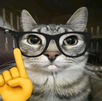
FIRST: Why do we even need these curves?
- Because your model gives probabilities, not just “yes/no”.
	- Example: A restaurant has a 0.72 chance of being critical. Another has 0.24 chance. Another 0.51 chance.
- Now YOU must decide: “At what cutoff should we call something ‘critical’?”
	- Is 0.50 the right threshold?
	- What if 0.30 gives better recall?
	- What if 0.80 gives better precision?
- The curves help you compare ALL possible thresholds at once.

What PR Curve Measures 
- PR curve tells you: If the model says “this is critical,” how often is it right? (precision)
- And how many critical violations does it actually catch? (recall)
	- It focuses ONLY on the important class (critical violations).
- Purpose: To see how good your model is at finding critical events without giving too many false alerts.
- PR curve = “How well can I catch the bad stuff?”

What ROC Curve Measures 
- ROC curve tells you: How well does the model separate critical vs not critical overall?
- It checks:
	- True positive rate
	- False positive rate
- ROC doesn’t care about class imbalance. It cares about the model’s general ability to rank positives higher than negatives.
- Purpose: To see if the model is good at ranking positives higher than negatives overall.
- ROC = “How well does my model separate the two groups?”

In [28]:
# my evaluation metric be PR, I will plot the PR curve and calc AP
from sklearn.metrics import average_precision_score, precision_recall_curve

y_scores = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)


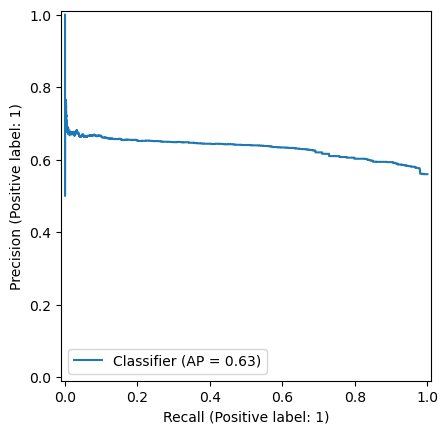

In [23]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_scores)
plt.show()


#### DEFINE AP (Average Precision) 
- AP is the area under the Precision-Recall curve.
- Basically how good is my model at catching the positive class across ALL thresholds?
- So Higher AP = better model.

My result was .63, AP scores are between 0 and 1, my score is fairly good I'd say for the two predictors I picked

#### graph insight
- The PR curve shows high precision at low recall; this means the model is very accurate when it flags only a few cases. As recall increases, precision decreases, reflecting the tradeoff between catching more critical violations and allowing more false positives

### 7) Try a Custom Threshold -- Update the code to fit your threshold and/or variable names from previous cells
Pick a threshold from your curve (e.g., a point balancing your business needs), then recompute metrics.

#### Picking a threshold
Based of the curve: 
- At low recall, precision is very high
- As recall increases, precision drops

This means:
- If I want high precision, I'd choose a higher threshold such as .75
- If I want a high recall, choose a low threshold such as .20

Given this context
- A restaurants inspections... missing a critical violation is super bad, so I think having a higher recall is important because we don't want to miss any cases that are critical
- Precision tells me how often my critical predictions are correct. Recall tells me how many real critical violations I successfully identified. In restaurant inspections, recall is more important because missing a true critical violation is more dangerous than raising a few extra false alerts

#### Breakdown of recap and precision because I keep messing it up 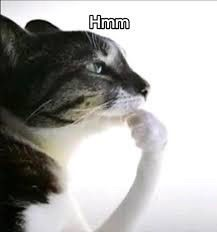
(I used apples as an examples)
- Precision
    - **Precision** = Of the cases I flagged as critical, how many were actually critical? (Let's further break this down)
        - You predicted 10 apples
        - 7 were actually apples
            - Precision = 7/10 = 0.70
        - This measures how accurate your predictions are when you say something is positive.

    - **Recall** = Of all the true critical cases that existed, how many did we find?
        - There were 20 apples in the world
        - You only found 10
            - Recall = 10/20 = 0.50
        - This measures how well your model catches **all** actually critical cases.

- **KEY DIFFERENCE** 
    - Precision is about your predictions.
        - “How correct were we out of the ones we flagged?”
    - Recall is about reality.
        - “How many real positives did we catch out of all that exist?”
- They are NOT the same, even though they sound similar.

##### Apple example
- Precision:
    - You picked 10 apples, 7 were real apples.
    - Precision = 7/10
- Recall: 
    - There were actually 20 apples out there, and you found 10.
    - Recall = 10/20


##### My question:
In restaurants, which metric is more important - precision or recall?

- So I asked myself: What’s worse?
    - To falsely accuse a restaurant of a critical violation (false positive -> hurts precision)
    - OR
    - To miss a real critical violation that can make someone sick (false negative -> hurts recall)

- To me: Missing a real critical violation = WORSE
    - because it puts people at risk.
    - So recall is more important in health inspections

### side note
- https://scikit-learn.org/stable/modules/classification_threshold.html
- if u go to section 3.2 and 3.3 its rlly helpful

In [ ]:
# I will pick a lower threshold to catch more critical violations, even if it means more false positives aka a higher recall but lower precision
# I'll try .40 as threshold
threshold = 0.40
y_pred_threshold = (y_scores >= threshold).astype(int)

In [44]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y_test, y_pred_threshold))
print(precision_score(y_test, y_pred_threshold))

1.0
0.5600676511238816


In [45]:
recall_score(y_test, y_pred_threshold)


1.0

### insight
After lowering the threshold to 0.40, my recall went up to 1.0, which means the model is catching every actual critical violation in the test set. My precision dropped to about 0.56, which means we are flagging more false positives, but that is acceptable in this situation because I chose to prioritize recall. In health inspections, missing a real critical violation is more dangerous than over-flagging a few extra restaurants. By lowering the threshold, the model becomes more sensitive and makes sure we don’t miss any true critical cases, even if that means the precision gets lower.

## We Share — Reflection (Post 2 short paragraphs)

1) **Curve choice & results:** Which curve did you use (**ROC** or **PR**) and **why** (tie to class balance & business costs)? Report your curve summary (**AUC-ROC** or **Average Precision**) and your chosen extra metric (**precision/recall/F1**) — include threshold (0.5 or custom). 
    - I chose to use the Precision-Recall (PR) curve because the dataset is highly imbalanced, with far fewer critical violations than non-critical ones. In this type of problem, the main risk is missing a true critical violation, which can put customers at risk, so recall is more important than precision. Precision would matter more if false alarms were very costly for businesses, but in health inspections, missing a true unsafe restaurant is far more dangerous than over-flagging a few extra locations. My model’s Average Precision (AP) was about 0.63, and using a custom threshold of 0.30, I achieved recall = 1.00 and precision ≈ 0.56. This means the model successfully caught all true critical violations (high recall), even though it produced more false positives (lower precision), which is an acceptable trade-off in this context.
2) **Stakeholder one-liner:** In plain English: “Using **[features…]**, our model at threshold **T** yields **[metric values]**. This means **[business implication about false alarms vs misses]**. Next, we’d **[tune threshold, add features, address imbalance, etc.]**.”
    - Using SCORE and BORO, our model at a 0.30 threshold achieves 1.0 recall and 0.56 precision.This means we’re choosing to catch every real critical violation, even if it means sending inspectors to a few restaurants that turn out fine. Next, we could improve the model by adding more features or tuning the threshold to reduce false alarms.
> Tip: If the positive class is rare, PR is often more informative than ROC. If classes are balanced or you’re comparing ranking quality across models, AUC-ROC is fine — but still report a confusion matrix at your chosen threshold.
